**Задание 1**

Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). 

In [1]:
import pandas as pd
import datetime
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Загрузим данные и посмотрим на них.

In [2]:
data_reg = pd.read_csv('~/shared/problem1-reg_data.csv', sep=';')
data_auth = pd.read_csv('~/shared/problem1-auth_data.csv', sep=';') 

In [3]:
reg = data_reg
auth = data_auth

In [4]:
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype
---  ------  --------------    -----
 0   reg_ts  1000000 non-null  int64
 1   uid     1000000 non-null  int64
dtypes: int64(2)
memory usage: 15.3 MB


In [5]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype
---  ------   -----
 0   auth_ts  int64
 1   uid      int64
dtypes: int64(2)
memory usage: 146.5 MB


Уберем строчку с NaN и переведем uid из float в int.

In [6]:
auth = auth.dropna()

In [7]:
auth['uid'] = auth['uid'].astype(np.int64)

Переведем дату в формат год-месяц-день-время.

In [8]:
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], unit='s')

Найдем самую раннюю и самую позднюю дату регистрации.

In [9]:
reg['reg_ts'].agg(['min', 'max'])

min   1998-11-18 09:43:43
max   2020-09-23 15:17:24
Name: reg_ts, dtype: datetime64[ns]

Как видно, размах данных больше 20 лет. В качестве сэмпла предлагаю взять самые свежие и полные данные. Поэтому отберем строки за август 2020 года, так как данные за сентрябрь 2020 года не полные.


In [10]:
def retention(registration, authentication):
    """ Первым этапом переведем секунды в датах в временной формат год-месяц-день.
        Далее выделим сэмпл.
        Соединим данные в один датафрейм по uid.
        Посчитаем количество дней между регистрацией и входом в игру.
        Сделам разделение на когорты и посчитаем retention.
        Зададим параметры графика."""
    
    registration['registration_date'] = pd.to_datetime(data_reg['reg_ts'], unit='s').dt.date
    authentication['authentication_date'] = pd.to_datetime(data_auth['auth_ts'], unit='s').dt.date
    
    registration = registration[(registration['registration_date'] >= datetime.date(2020, 8, 1))]
    authentication = authentication[(authentication['authentication_date'] <= datetime.date(2020, 8, 31))]

    df_all = pd.merge(authentication, registration, on='uid')
    
    df_all['retention'] = (df_all['authentication_date'] - df_all['registration_date']).dt.days + 1

    cohorts_ret = df_all.groupby(['registration_date', 'retention'])['uid'].nunique().reset_index() 
    cohorts = cohorts_ret.pivot(index='registration_date', columns='retention', values='uid') 
    base = cohorts[1] 
    retention = cohorts.divide(base, axis=0).round(3)
    
    plt.figure(figsize=(20, 15))
    plt.title('Retention_N_Days')
    ax = sns.heatmap(data=retention, annot=True, fmt='.0%', vmin=0.0, vmax=0.1, cmap='mako')
    ax.set_yticklabels(retention.index)
    plt.show()

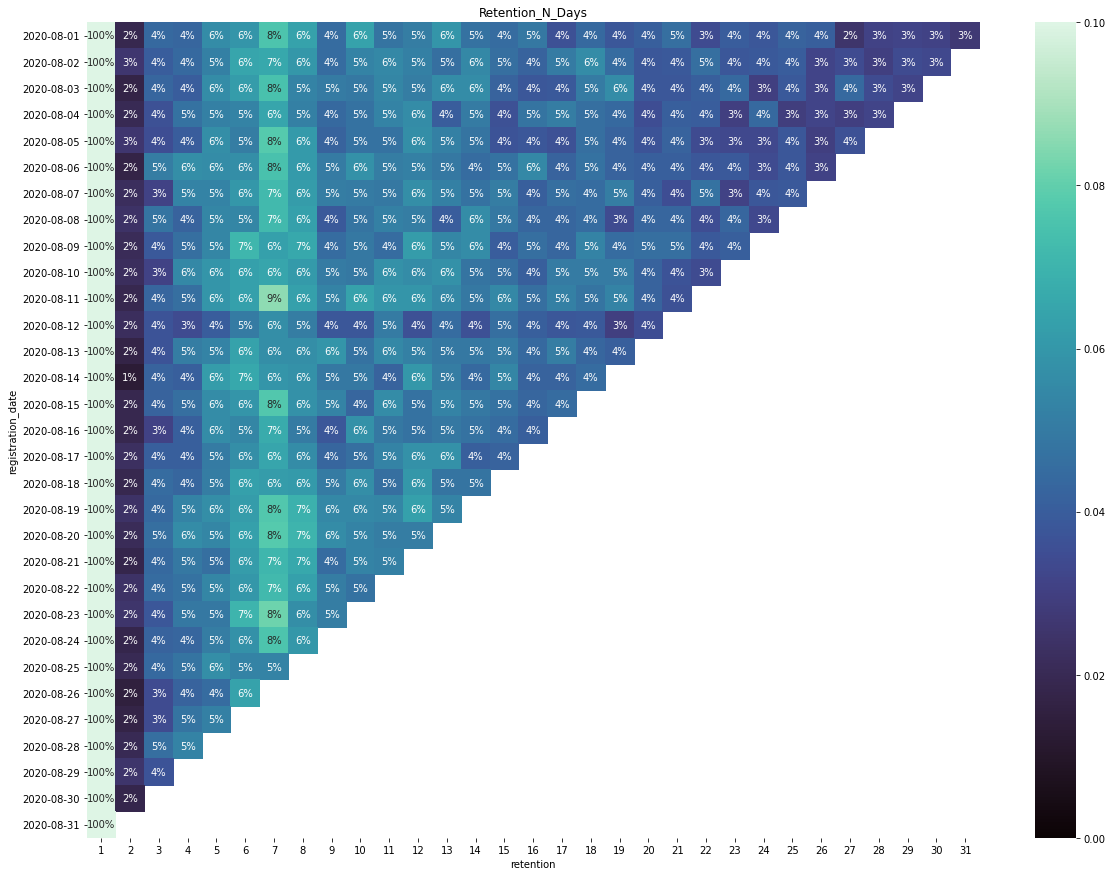

In [11]:
retention(data_reg, data_auth)

Как видно из таблицы выше, максимума retention достигает на 7 день. Обычно в мобильных играх к концу недели активности игроки получают весомые бонусы, как видно далее вторую неделю retention сохраняется на уверенном уровне. Но на последней неделе месяца retention падает до 3%. Предположу, что связано это, скорее всего, с 2-мя вещами: недостаточно ценными наградами за месяц игры и с выходом на рутинный гемплей.